In [ ]:
import os

# LoRa on finegrained data

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p /scratch/data/
!cp /content/drive/MyDrive/Datasets/finegrained_dataset_mk2.zip /scratch/data

In [ ]:
!unzip /scratch/data/finegrained_dataset_mk2.zip -d /scratch;

Archive:  /scratch/data/finegrained_dataset_mk2.zip
   creating: /scratch/merged/test/ArmChairs/
   creating: /scratch/merged/test/ArmChairs/ArmChair2/
 extracting: /scratch/merged/test/ArmChairs/ArmChair2/9.png  
 extracting: /scratch/merged/test/ArmChairs/ArmChair2/7.png  
 extracting: /scratch/merged/test/ArmChairs/ArmChair2/10.png  
  inflating: /scratch/merged/test/ArmChairs/ArmChair2/1.png  
  inflating: /scratch/merged/test/ArmChairs/ArmChair2/6.png  
 extracting: /scratch/merged/test/ArmChairs/ArmChair2/8.png  
 extracting: /scratch/merged/test/ArmChairs/ArmChair2/3.png  
 extracting: /scratch/merged/test/ArmChairs/ArmChair2/2.png  
  inflating: /scratch/merged/test/ArmChairs/ArmChair2/4.png  
 extracting: /scratch/merged/test/ArmChairs/ArmChair2/5.png  
   creating: /scratch/merged/test/ArmChairs/ArmChair1/
 extracting: /scratch/merged/test/ArmChairs/ArmChair1/9.png  
  inflating: /scratch/merged/test/ArmChairs/ArmChair1/7.png  
  inflating: /scratch/merged/test/ArmChairs/ArmC

In [ ]:
!pip install transformers accelerate evaluate datasets peft -q
from transformers import CLIPProcessor, CLIPModel, AutoProcessor, AutoModelForImageClassification, TrainingArguments, Trainer, AutoImageProcessor

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.6/85.6 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 68.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.9 MB/s eta 0:00:00


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import PIL
import os
import random

from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

from tqdm import tqdm
from transformers import AutoImageProcessor, CLIPVisionModel

In [ ]:
# vit

model_checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(model_checkpoint)

# clip

# model_checkpoint = "openai/clip-vit-base-patch32"
# image_processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [ ]:
#create dataloaders to create and store triplets

# BUG: maybe dont individually

class ObjectTriplets(Dataset):
  def __init__(self, dataset_path, transforms, num_triplets_per_class=None, difficult_triplet_percentage=None):
    if transforms == None:
      self.transform = ToTensor()
    else:
      self.transform = transforms

    self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
    self.triplets = self.get_triplets(dataset_path, num_triplets_per_class=num_triplets_per_class)

  def pick_random(self, arr, val):
    if not arr:
      return None

    k = val
    while k == val:
      k = random.choice(arr)
      # print(k,val)
    return k

  # no negative mining so far, address class balance by creating a fixed number of triplets for each class
  def get_triplets(self, dataset_path, num_triplets_per_class=None, difficult_triplet_percentage=None):
    triplets = []

    categories = os.listdir(dataset_path)
    classes = []

    for ctg in categories:
      for i in os.listdir(os.path.join(dataset_path, ctg)):
        classes.append(ctg + '/' + i)

    print(classes)

    image_paths = [[os.path.join(
                        dataset_path,
                        c,
                        n,
                    ) for n in os.listdir(os.path.join(dataset_path, c))]
                   for c in classes]
    random.shuffle(image_paths)

    if num_triplets_per_class == None:
      self.num_triplets_per_class = max([len(c) for c in image_paths])
    else:
      self.num_triplets_per_class = num_triplets_per_class

    with tqdm(total = self.num_triplets_per_class * len(classes)) as pbar:
      for cidx, c in enumerate(classes):

        coarse_ctg = c[:c.find('/')]
        easy_classes  = [i for i in range(len(classes)) if (i != cidx and coarse_ctg != classes[i][:classes[i].find('/')])]
        tough_classes = [i for i in range(len(classes)) if (i != cidx and coarse_ctg == classes[i][:classes[i].find('/')])]

        other_classes = [i for i in range(len(classes)) if i != cidx]
        for i in range(self.num_triplets_per_class):
          if i >= len(image_paths[cidx]):
            idx = random.randint(0, len(image_paths[cidx]) - 1)
          else:
            idx = i

          anchor_path = image_paths[cidx][idx]
          positive_path = self.pick_random(image_paths[cidx],
                                            image_paths[cidx][idx])


          if difficult_triplet_percentage == None:
            negative_path = self.pick_random(image_paths[random.choice(other_classes)],
                                              image_paths[cidx][idx])
          else:
            if i < int(difficult_triplet_percentage * self.num_triplets_per_class):
              negative_path = self.pick_random(image_paths[random.choice(tough_classes)], image_paths[cidx][idx])
            else:
              negative_path = self.pick_random(image_paths[random.choice(easy_classes)], image_paths[cidx][idx])

          triplet = [
              self.transform(PIL.Image.open(anchor_path)),
              self.transform(PIL.Image.open(positive_path)),
              self.transform(PIL.Image.open(negative_path))
          ]

          triplet = torch.stack(triplet)

          # print(triplet)
          # print([anchor_path, positive_path, negative_path])
          triplets.append(triplet)
          pbar.update(1)

    return triplets

  def __len__(self):
    return len(self.triplets)

  ##
  def __getitem__(self, idx):
    return self.triplets[idx]


In [ ]:
image_processor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [ ]:
# image_processor.image_processor

In [ ]:
# vit
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
train_transforms = Compose(
    [
        RandomResizedCrop(image_processor.size["height"]),
        RandomHorizontalFlip(),
        ToTensor(),
        normalize,
    ]
)

val_transforms = Compose(
    [
        Resize(image_processor.size["height"]),
        CenterCrop(image_processor.size["height"]),
        ToTensor(),
        normalize,
    ]
)

test_transforms = Compose(
    [
        Resize(image_processor.size["height"]),
        CenterCrop(image_processor.size["height"]),
        ToTensor(),
        normalize,
    ]
)

# clip

# normalize = Normalize(mean=image_processor.image_processor.image_mean, std=image_processor.image_processor.image_std)
# train_transforms = Compose(
#     [
#         RandomResizedCrop(image_processor.image_processor.crop_size["height"]),
#         RandomHorizontalFlip(),
#         ToTensor(),
#         normalize,
#     ]
# )

# val_transforms = Compose(
#     [
#         Resize(image_processor.image_processor.size["shortest_edge"]),
#         CenterCrop(image_processor.image_processor.crop_size["height"]),
#         ToTensor(),
#         normalize,
#     ]
# )

# test_transforms = Compose(
#     [
#         Resize(image_processor.image_processor.size["shortest_edge"]),
#         CenterCrop(image_processor.image_processor.crop_size["height"]),
#         ToTensor(),
#         normalize,
#     ]
# )

In [ ]:
batch_size = 8

train_dataset = ObjectTriplets('/scratch/merged/train', train_transforms, num_triplets_per_class=140, difficult_triplet_percentage=0.75)
val_dataset = ObjectTriplets('/scratch/merged/val', val_transforms, num_triplets_per_class=40, difficult_triplet_percentage=0.75)
test_dataset = ObjectTriplets('/scratch/merged/test', test_transforms, num_triplets_per_class=20, difficult_triplet_percentage=0.75)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

['Chairs/Chair4', 'Chairs/Chair2', 'Chairs/Chair3', 'Chairs/Chair1', 'Chairs/Chair5', 'ArmChairs/ArmChair3', 'ArmChairs/ArmChair4', 'ArmChairs/ArmChair2', 'ArmChairs/ArmChair1', 'Tables/Table1', 'Tables/Table2', 'Tables/Table4', 'Tables/Table3']


100%|██████████| 1820/1820 [00:28<00:00, 63.98it/s]


['Chairs/Chair4', 'Chairs/Chair2', 'Chairs/Chair3', 'Chairs/Chair1', 'Chairs/Chair5', 'ArmChairs/ArmChair3', 'ArmChairs/ArmChair4', 'ArmChairs/ArmChair2', 'ArmChairs/ArmChair1', 'Tables/Table1', 'Tables/Table2', 'Tables/Table4', 'Tables/Table3']


100%|██████████| 520/520 [00:10<00:00, 48.22it/s]


['Chairs/Chair4', 'Chairs/Chair2', 'Chairs/Chair3', 'Chairs/Chair1', 'Chairs/Chair5', 'ArmChairs/ArmChair3', 'ArmChairs/ArmChair4', 'ArmChairs/ArmChair2', 'ArmChairs/ArmChair1', 'Tables/Table1', 'Tables/Table2', 'Tables/Table4', 'Tables/Table3']


100%|██████████| 260/260 [00:05<00:00, 50.01it/s]


In [ ]:
test_triplet = next(iter(train_loader))
test_triplet

tensor([[[[[ 0.4196,  0.2235, -0.2627,  ...,  0.2706,  0.2784,  0.2784],
           [ 0.4196,  0.2235, -0.2627,  ...,  0.2706,  0.2784,  0.2784],
           [ 0.4196,  0.2235, -0.2627,  ...,  0.2706,  0.2784,  0.2784],
           ...,
           [ 0.1529,  0.1922,  0.2863,  ...,  0.4431,  0.4510,  0.4510],
           [ 0.0196,  0.0980,  0.2941,  ...,  0.3961,  0.4039,  0.4039],
           [-0.0118,  0.0745,  0.2941,  ...,  0.3882,  0.3882,  0.3882]],

          [[ 0.3725,  0.1843, -0.2863,  ...,  0.2314,  0.2314,  0.2314],
           [ 0.3725,  0.1843, -0.2863,  ...,  0.2314,  0.2314,  0.2314],
           [ 0.3725,  0.1843, -0.2863,  ...,  0.2314,  0.2314,  0.2314],
           ...,
           [-0.2314, -0.2549, -0.3020,  ...,  0.1137,  0.1137,  0.1137],
           [-0.4510, -0.4510, -0.4431,  ...,  0.0667,  0.0667,  0.0667],
           [-0.5059, -0.4980, -0.4745,  ...,  0.0588,  0.0510,  0.0510]],

          [[ 0.2235,  0.0588, -0.3647,  ...,  0.0667,  0.0667,  0.0667],
           [ 0.

## Set up model configs

In [ ]:
from transformers import ViTConfig, ViTModel, ViTForImageClassification
from transformers import CLIPVisionModel

# vit

pretrained_model = ViTModel.from_pretrained(
    model_checkpoint,
    ignore_mismatched_sizes=True
)

# the first patch is the CLS token
pretrained_model


# clip

# pretrained_model = CLIPVisionModel.from_pretrained(
#     model_checkpoint,
#     ignore_mismatched_sizes=True
# )

# # the first patch is the CLS token
# pretrained_model

ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation(

In [ ]:
# print(len(output.last_hidden_state))
# print((output.last_hidden_state).shape)
# print()

# cls_token = output.last_hidden_state[:,0,:]
# print(cls_token.shape)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# set up the lora config

from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,

    # vit
    target_modules=["query", "value"],

    # clip
    # target_modules=["q_proj", "v_proj"],
    lora_dropout=0.1,
    bias="none",
    modules_to_save=["classifier"],
)
lora_model = get_peft_model(pretrained_model, lora_config).to(device)

print(lora_model)

PeftModel(
  (base_model): LoraModel(
    (model): ViTModel(
      (embeddings): ViTEmbeddings(
        (patch_embeddings): ViTPatchEmbeddings(
          (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ViTEncoder(
        (layer): ModuleList(
          (0-11): 12 x ViTLayer(
            (attention): ViTAttention(
              (attention): ViTSelfAttention(
                (query): Linear(
                  in_features=768, out_features=768, bias=True
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.1, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=768, out_features=8, bias=False)
                  )
                  (lora_B): ModuleDict(
                    (default): Linear(in_features=8, out_features=768, bias=False)
                  )
                  (lora_emb

In [ ]:
# compare trainable param count
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )

pretrained_model = ViTModel.from_pretrained(
    model_checkpoint,
    ignore_mismatched_sizes=True
)

print("No LoRa: ", end='')
print_trainable_parameters(pretrained_model)
print("With LoRa: ", end='')
print_trainable_parameters(lora_model)

No LoRa: trainable params: 86389248 || all params: 86389248 || trainable%: 100.00
With LoRa: trainable params: 294912 || all params: 86684160 || trainable%: 0.34


## Main training loop

In [ ]:
# returns embeddings for anchor, positive and negative images
def get_embeddings(model, batch):
    # get cls tokens directly
    a_embs = model(batch[:, 0, ...], output_hidden_states=True).last_hidden_state[:,0,:]
    p_embs = model(batch[:, 1, ...], output_hidden_states=True).last_hidden_state[:,0,:]
    n_embs = model(batch[:, 2, ...], output_hidden_states=True).last_hidden_state[:,0,:]

    return a_embs, p_embs, n_embs

def get_triplet_loss(a_embs, p_embs, n_embs, bias_val=0.0):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    bias = torch.ones(a_embs.shape[0]).float() * bias_val
    bias = bias.to(device)

    z = torch.zeros(a_embs.shape[0]).float().to(device)

    loss = torch.max(z,
               (
                  bias +
                  torch.linalg.norm(a_embs - p_embs, dim=1) -
                  torch.linalg.norm(a_embs - n_embs, dim=1)
               ))

    loss = torch.sum(loss)

    return loss

In [ ]:
import copy
t = copy.copy(test_triplet).to('cuda' if torch.cuda.is_available() else 'cpu')

# print(test_triplet[0].shape, test_triplet[1].shape, test_triplet[2].shape)
print(t[:,0,...])

tensor([[[[ 0.4196,  0.2235, -0.2627,  ...,  0.2706,  0.2784,  0.2784],
          [ 0.4196,  0.2235, -0.2627,  ...,  0.2706,  0.2784,  0.2784],
          [ 0.4196,  0.2235, -0.2627,  ...,  0.2706,  0.2784,  0.2784],
          ...,
          [ 0.1529,  0.1922,  0.2863,  ...,  0.4431,  0.4510,  0.4510],
          [ 0.0196,  0.0980,  0.2941,  ...,  0.3961,  0.4039,  0.4039],
          [-0.0118,  0.0745,  0.2941,  ...,  0.3882,  0.3882,  0.3882]],

         [[ 0.3725,  0.1843, -0.2863,  ...,  0.2314,  0.2314,  0.2314],
          [ 0.3725,  0.1843, -0.2863,  ...,  0.2314,  0.2314,  0.2314],
          [ 0.3725,  0.1843, -0.2863,  ...,  0.2314,  0.2314,  0.2314],
          ...,
          [-0.2314, -0.2549, -0.3020,  ...,  0.1137,  0.1137,  0.1137],
          [-0.4510, -0.4510, -0.4431,  ...,  0.0667,  0.0667,  0.0667],
          [-0.5059, -0.4980, -0.4745,  ...,  0.0588,  0.0510,  0.0510]],

         [[ 0.2235,  0.0588, -0.3647,  ...,  0.0667,  0.0667,  0.0667],
          [ 0.2235,  0.0588, -

In [ ]:
a,p,n = get_embeddings(lora_model, t)

In [ ]:
loss = get_triplet_loss(a,p,n, bias_val=2)

In [ ]:
loss

tensor(12.7332, device='cuda:0', grad_fn=<SumBackward0>)

## Evaluate before finetuning

In [ ]:
# Visualise test set images

# Load all test images
test_path =  '/scratch/merged/test'

categories = os.listdir(test_path)
test_classes = []
for ctg in categories:
  for i in os.listdir(os.path.join(test_path, ctg)):
    test_classes.append(ctg + '/' + i)

test_classes = sorted(test_classes)

test_images = [
    os.listdir(os.path.join(
        test_path,
        c
    )) for c in test_classes
]

for i in range(len(test_classes)):
  for j in range(len(test_images[i])):
    test_images[i][j] = os.path.join(test_path, test_classes[i], test_images[i][j])

In [ ]:
for i in range(len(test_classes)):
  for j in range(len(test_images[i])):
    test_images[i][j] = PIL.Image.open(test_images[i][j])

100%|██████████| 13/13 [00:01<00:00, 11.62it/s]


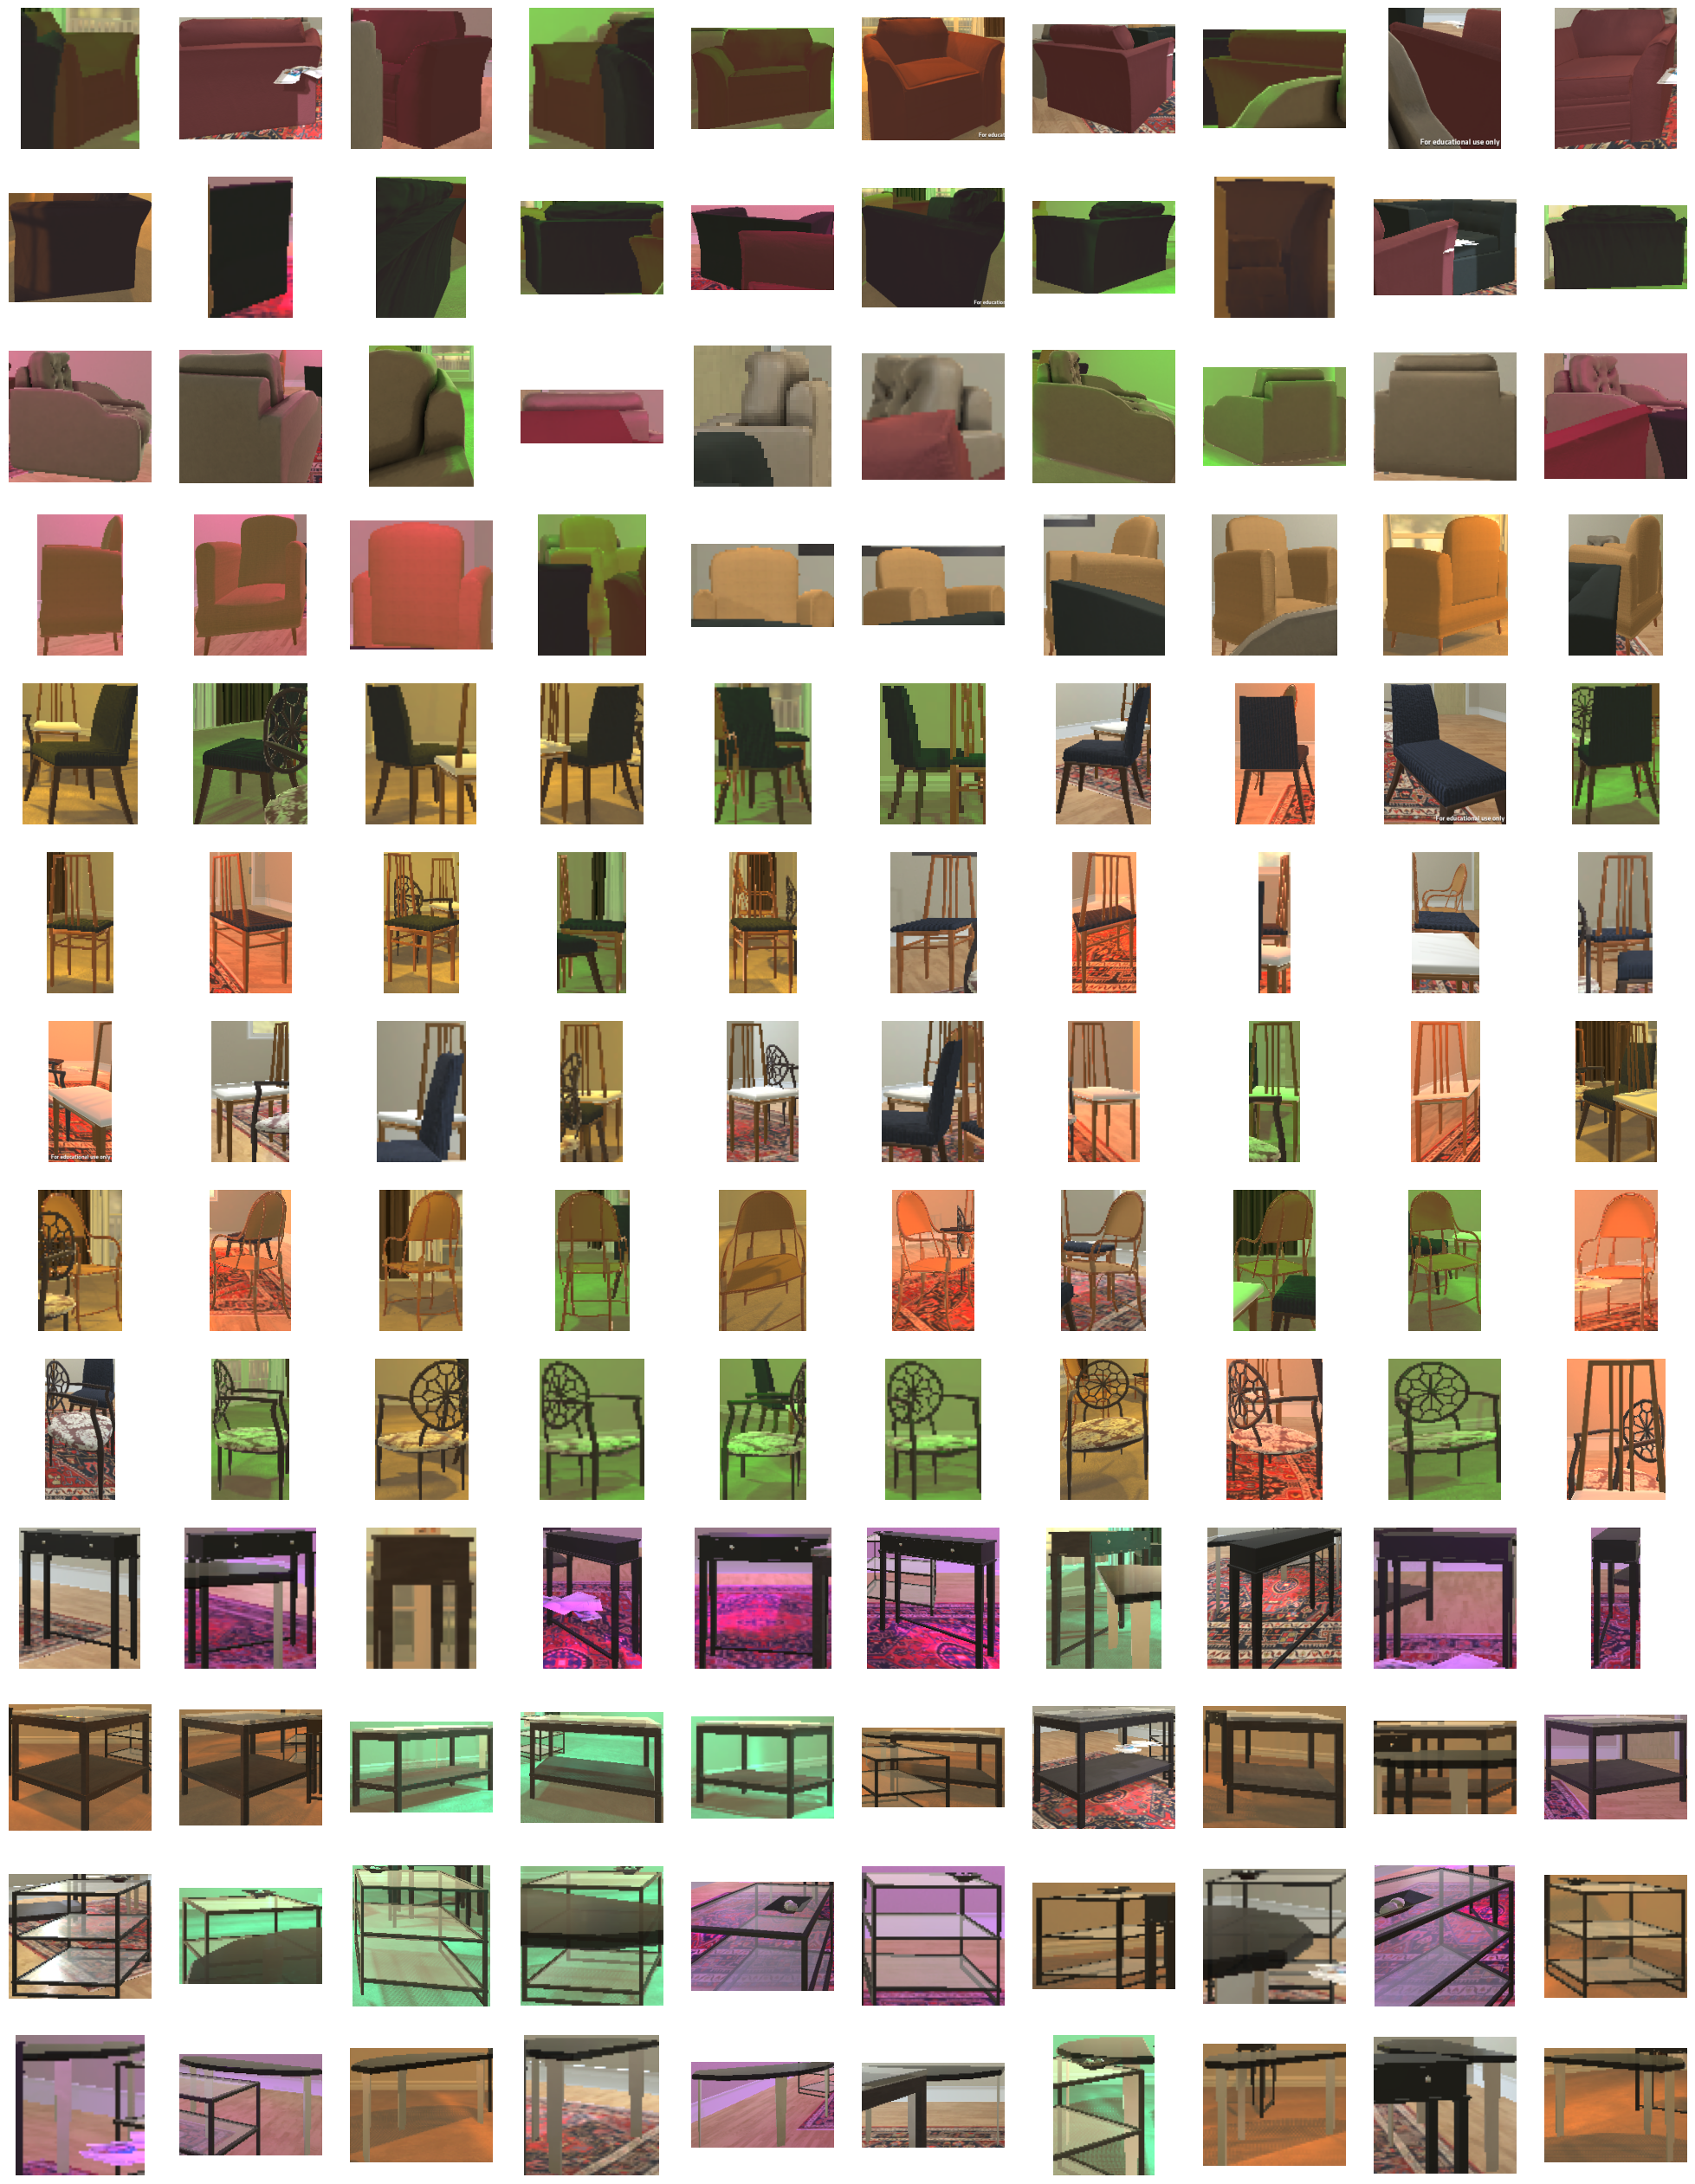

In [ ]:
import matplotlib.pyplot as plt

to_show = 10
fig, axes = plt.subplots(len(test_classes), to_show, figsize=(to_show * 2.5, len(test_classes) * 2.5))

for i in tqdm(range(len(test_classes))):
  for j, img in enumerate(test_images[i][:to_show]):
    ax = axes[i][j]
    ax.imshow(img)
    ax.axis('off')  # Hide axis

plt.show()


In [ ]:
# get all embeddings

w = []

with torch.no_grad():
  for row in test_images:
    r = []
    for i in row:
      im = test_transforms(i)
      k = lora_model(im.unsqueeze(0).cuda(), output_hidden_states=True).last_hidden_state[0,0,:]

      r.append(k)
    w.append(torch.stack(r))
w = torch.stack(w).reshape(-1, 768)

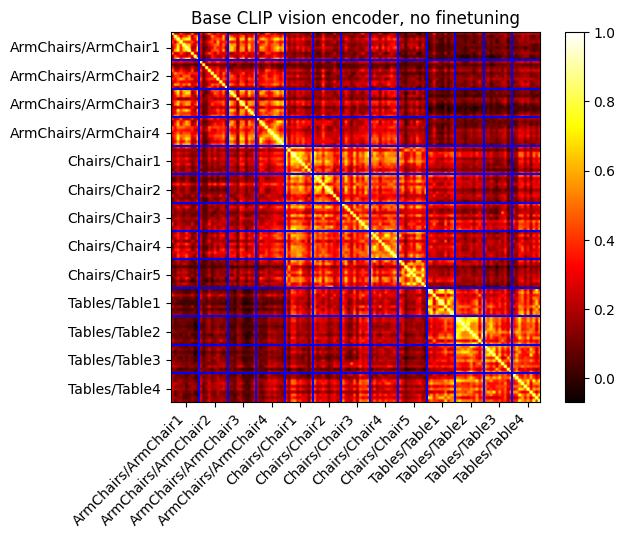

In [ ]:
# get heatmap

import torch.nn.functional as F

scores = (F.cosine_similarity(w.unsqueeze(0), w.unsqueeze(1), axis=-1)).detach().cpu().numpy()

plt.imshow(scores, cmap='hot')
plt.colorbar()

x_axis_titles = [f"{test_classes[i//10]}" for i in range(5, 5 + len(scores), 10)]
y_axis_titles = [f"{test_classes[i//10]}" for i in range(5, 5 + len(scores), 10)]

plt.xticks(range(5, 5 + len(scores), 10), x_axis_titles, rotation=45, ha='right')
plt.yticks(range(5, 5 + len(scores), 10), y_axis_titles, va='center')

for i in range(1, len(scores)):
    if i % 10 == 0:
        plt.axvline(x=i - 0.5, color='blue', linestyle='-', linewidth=1.5)
        plt.axhline(y=i - 0.5, color='blue', linestyle='-', linewidth=1.5)


# Show the heatmap
plt.title("Base CLIP vision encoder, no finetuning")

plt.show()

## Training loop

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class train_config():
  def __init__(self,
               r=16,
               bias=1.0,
               batch_size=16,
               num_epochs=10,
               ):
    self.r = r
    self.bias = bias
    self.batch_size = batch_size
    self.num_epochs = num_epochs

def train(model, train_loader, val_loader, optimizer, config):
    """
    Generic training loop for PyTorch models.

    Args:
    model: The neural network model to train.
    train_loader: DataLoader for the training dataset.
    criterion: The loss function (e.g., nn.CrossEntropyLoss).
    optimizer: The optimizer (e.g., optim.SGD or optim.Adam).
    device: The device (CPU or GPU) to perform training.
    num_epochs: The number of training epochs.

    Returns:
    None
    """
    model.to(device)
    model.train()  # Set the model to training mode

    for epoch in range(config.num_epochs):
        print("Epoch: ", epoch+1)
        running_loss = 0.0

        for triplet in tqdm(train_loader):
            triplet = triplet.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            a,p,n = get_embeddings(lora_model, triplet)
            loss = get_triplet_loss(a,p,n, config.bias)

            # Backpropagation
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Calculate the average loss for this epoch
        epoch_loss = running_loss / len(train_loader)

        # Calculate validation loss
        val_running_loss = 0.0
        with torch.no_grad():
          for val_triplet in val_loader:
            a,p,n = get_embeddings(lora_model, triplet)
            val_loss = get_triplet_loss(a,p,n, config.bias)

            val_running_loss += val_loss.item()

        val_epoch_loss = val_running_loss / len(val_loader)


        print(f"Epoch [{epoch + 1}/{config.num_epochs}] - Loss: {epoch_loss:.4f} - Validation loss: {val_epoch_loss:.4}")
        print()

    print("Training complete.")

# Example usage:
# train(model, train_loader, nn.CrossEntropyLoss(), optim.Adam(model.parameters(), lr=0.001), "cuda", num_epochs=10)

In [ ]:
optimizer = optim.Adam(lora_model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

train_cfg = train_config(bias=2.5)
train(lora_model, train_loader, val_loader, optimizer, train_cfg)

Epoch:  1


100%|██████████| 228/228 [02:07<00:00,  1.79it/s]


Epoch [1/10] - Loss: 7.7117 - Validation loss: 0.0

Epoch:  2


100%|██████████| 228/228 [02:08<00:00,  1.77it/s]


Epoch [2/10] - Loss: 3.6768 - Validation loss: 0.0

Epoch:  3


100%|██████████| 228/228 [02:08<00:00,  1.78it/s]


Epoch [3/10] - Loss: 2.3490 - Validation loss: 0.0

Epoch:  4


100%|██████████| 228/228 [02:07<00:00,  1.78it/s]


Epoch [4/10] - Loss: 1.4896 - Validation loss: 0.0276

Epoch:  5


100%|██████████| 228/228 [02:07<00:00,  1.79it/s]


Epoch [5/10] - Loss: 1.1606 - Validation loss: 0.02082

Epoch:  6


100%|██████████| 228/228 [02:07<00:00,  1.79it/s]


Epoch [6/10] - Loss: 0.7768 - Validation loss: 0.0

Epoch:  7


100%|██████████| 228/228 [02:07<00:00,  1.79it/s]


Epoch [7/10] - Loss: 0.6774 - Validation loss: 0.0

Epoch:  8


100%|██████████| 228/228 [02:07<00:00,  1.79it/s]


Epoch [8/10] - Loss: 0.3555 - Validation loss: 0.0

Epoch:  9


100%|██████████| 228/228 [02:06<00:00,  1.80it/s]


Epoch [9/10] - Loss: 0.2347 - Validation loss: 0.0

Epoch:  10


100%|██████████| 228/228 [02:06<00:00,  1.80it/s]


Epoch [10/10] - Loss: 0.3401 - Validation loss: 0.0

Training complete.


## Evaluate on test set

In [ ]:
# Visualise test set images

# Load all test images
test_path =  '/scratch/merged/test'

categories = os.listdir(test_path)
test_classes = []
for ctg in categories:
  for i in os.listdir(os.path.join(test_path, ctg)):
    test_classes.append(ctg + '/' + i)

test_classes = sorted(test_classes)

test_images = [
    os.listdir(os.path.join(
        test_path,
        c
    )) for c in test_classes
]

for i in range(len(test_classes)):
  for j in range(len(test_images[i])):
    test_images[i][j] = os.path.join(test_path, test_classes[i], test_images[i][j])

In [ ]:
for i in range(len(test_classes)):
  for j in range(len(test_images[i])):
    test_images[i][j] = PIL.Image.open(test_images[i][j])

100%|██████████| 13/13 [00:00<00:00, 51.92it/s]


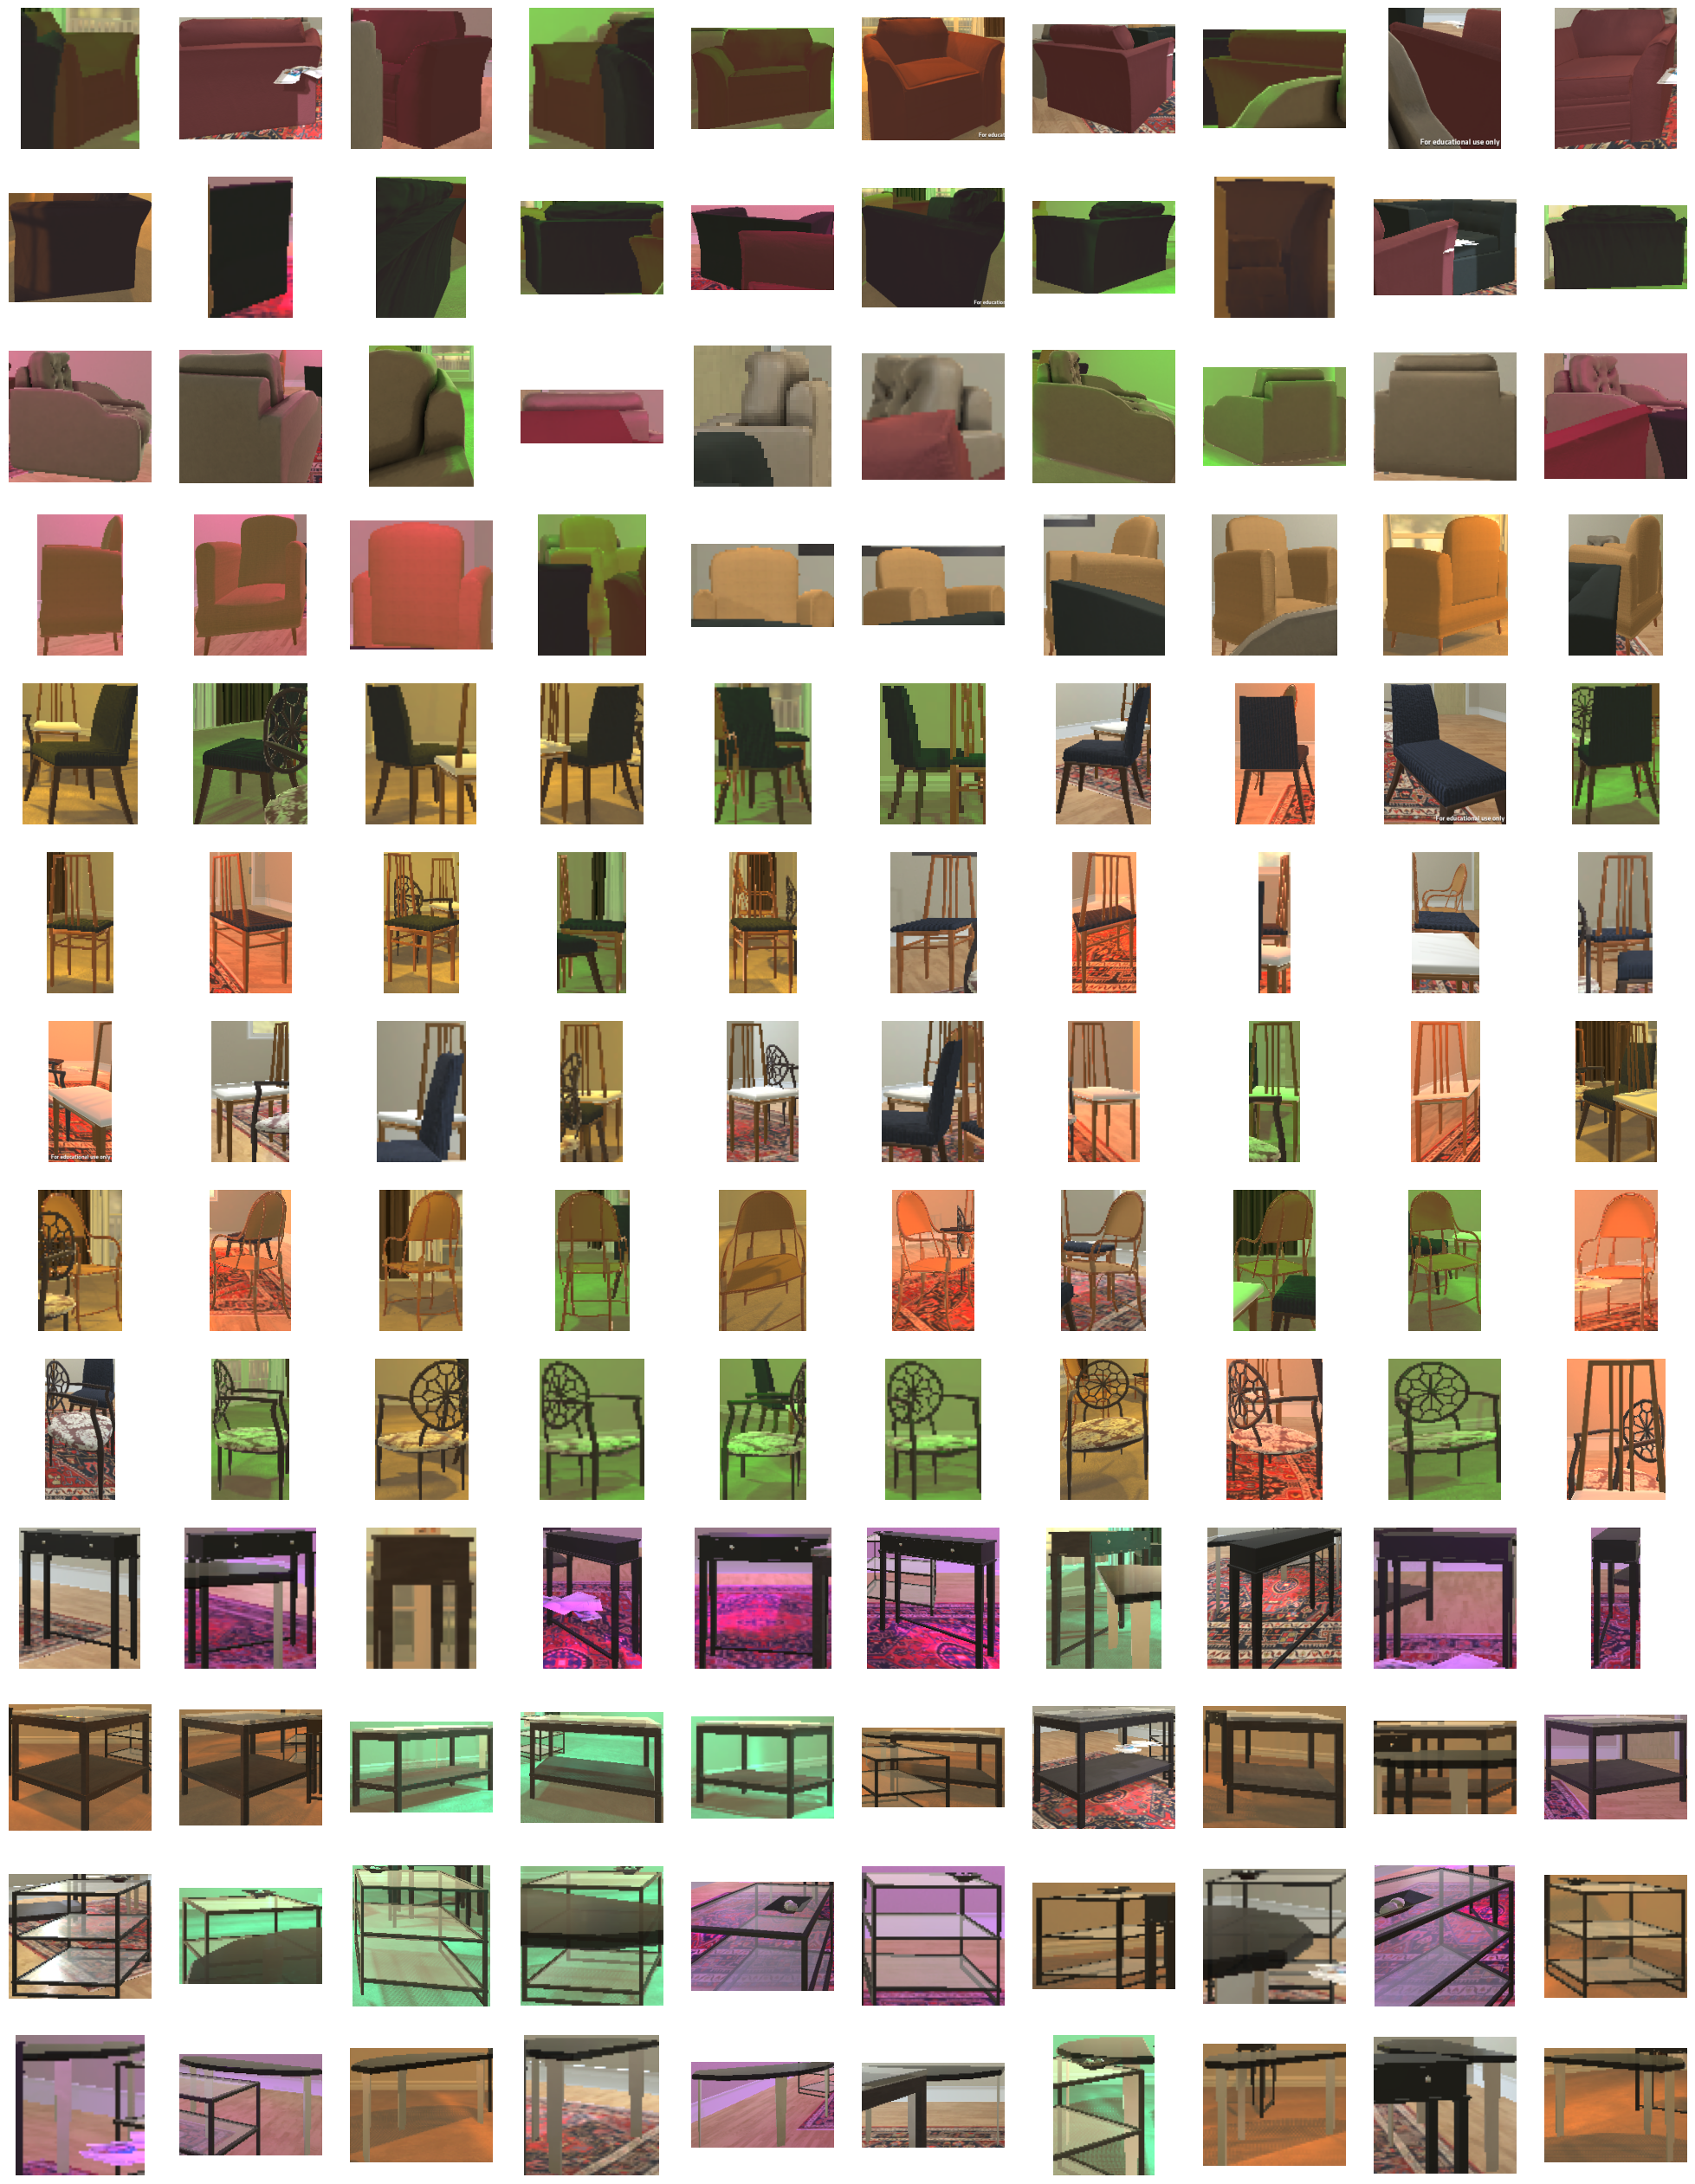

In [ ]:
import matplotlib.pyplot as plt

to_show = 10
fig, axes = plt.subplots(len(test_classes), to_show, figsize=(to_show * 2.5, len(test_classes) * 2.5))

for i in tqdm(range(len(test_classes))):
  for j, img in enumerate(test_images[i][:to_show]):
    ax = axes[i][j]
    ax.imshow(img)
    ax.axis('off')  # Hide axis

plt.show()


In [ ]:
# get all embeddings

w = []

with torch.no_grad():
  for row in test_images:
    r = []
    for i in row:
      im = test_transforms(i)
      k = lora_model(im.unsqueeze(0).cuda(), output_hidden_states=True).last_hidden_state[0,0,:]

      r.append(k)
    w.append(torch.stack(r))
w = torch.stack(w).reshape(-1, 768)

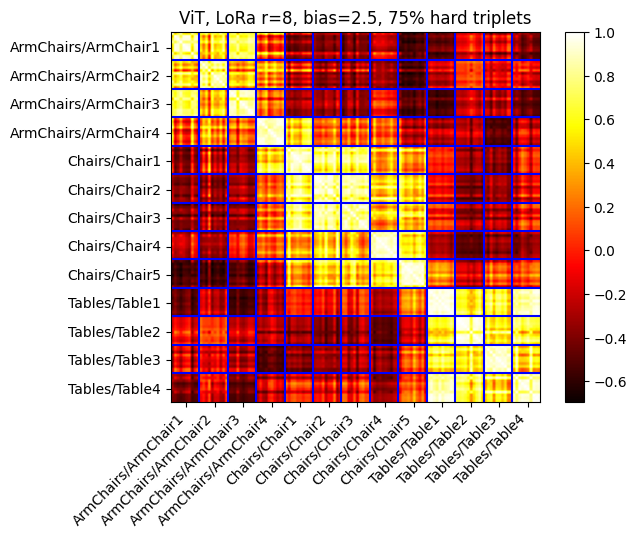

In [ ]:
# get heatmap

import torch.nn.functional as F

scores = (F.cosine_similarity(w.unsqueeze(0), w.unsqueeze(1), axis=-1)).detach().cpu().numpy()

plt.imshow(scores, cmap='hot')
plt.colorbar()

x_axis_titles = [f"{test_classes[i//10]}" for i in range(5, 5 + len(scores), 10)]
y_axis_titles = [f"{test_classes[i//10]}" for i in range(5, 5 + len(scores), 10)]

plt.xticks(range(5, 5 + len(scores), 10), x_axis_titles, rotation=45, ha='right')
plt.yticks(range(5, 5 + len(scores), 10), y_axis_titles, va='center')

for i in range(1, len(scores)):
    if i % 10 == 0:
        plt.axvline(x=i - 0.5, color='blue', linestyle='-', linewidth=1.5)
        plt.axhline(y=i - 0.5, color='blue', linestyle='-', linewidth=1.5)


# Show the heatmap
plt.title("ViT, LoRa r=8, bias=2.5, 75% hard triplets")

plt.show()

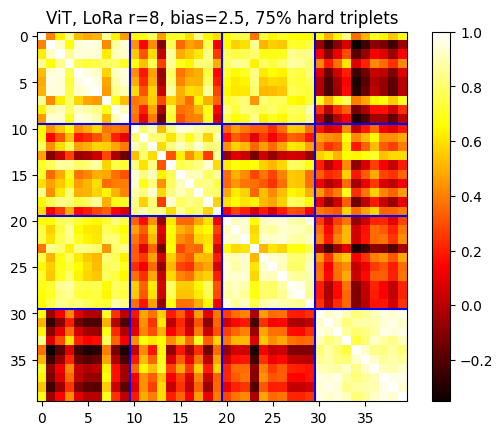

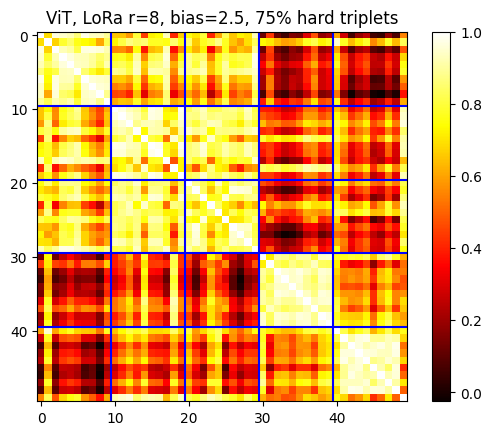

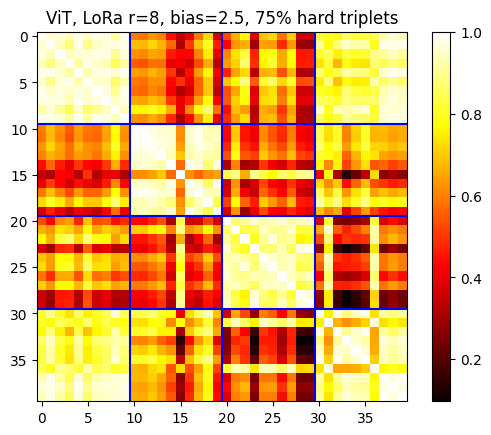

In [ ]:
# plot within each coarse category
# armchairs

# get heatmap

import torch.nn.functional as F

scores = (F.cosine_similarity(w.unsqueeze(0), w.unsqueeze(1), axis=-1)).detach().cpu().numpy()[:40,:40]

plt.imshow(scores, cmap='hot')
plt.colorbar()


for i in range(1, len(scores)):
    if i % 10 == 0:
        plt.axvline(x=i - 0.5, color='blue', linestyle='-', linewidth=1.5)
        plt.axhline(y=i - 0.5, color='blue', linestyle='-', linewidth=1.5)


# Show the heatmap
plt.title("ViT, LoRa r=8, bias=2.5, 75% hard triplets")

plt.show()

# chairs
scores = (F.cosine_similarity(w.unsqueeze(0), w.unsqueeze(1), axis=-1)).detach().cpu().numpy()[40:90,40:90]

plt.imshow(scores, cmap='hot')
plt.colorbar()


for i in range(1, len(scores)):
    if i % 10 == 0:
        plt.axvline(x=i - 0.5, color='blue', linestyle='-', linewidth=1.5)
        plt.axhline(y=i - 0.5, color='blue', linestyle='-', linewidth=1.5)


# Show the heatmap
plt.title("ViT, LoRa r=8, bias=2.5, 75% hard triplets")

plt.show()



# tables
scores = (F.cosine_similarity(w.unsqueeze(0), w.unsqueeze(1), axis=-1)).detach().cpu().numpy()[90:,90:]

plt.imshow(scores, cmap='hot')
plt.colorbar()


for i in range(1, len(scores)):
    if i % 10 == 0:
        plt.axvline(x=i - 0.5, color='blue', linestyle='-', linewidth=1.5)
        plt.axhline(y=i - 0.5, color='blue', linestyle='-', linewidth=1.5)


# Show the heatmap
plt.title("ViT, LoRa r=8, bias=2.5, 75% hard triplets")

plt.show()

  0%|          | 0/200 [00:00<?, ?it/s]

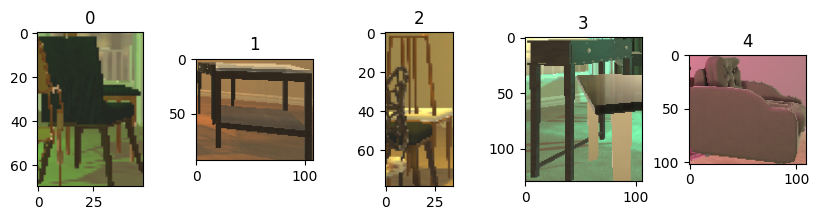

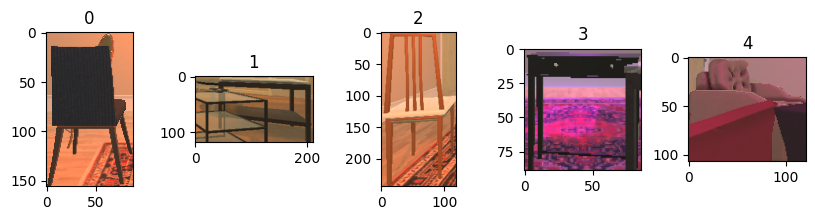


Hungarian algorithm
[0 1 2 3 4] [0 1 2 3 4]


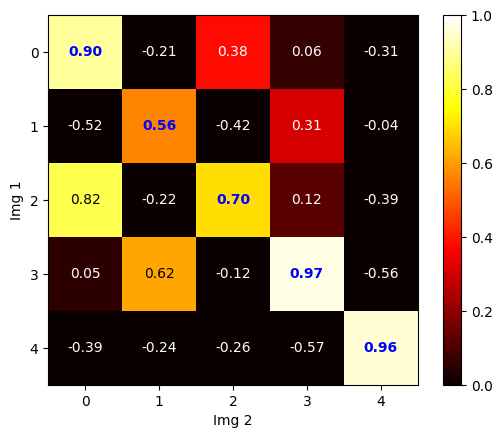

  1%|          | 2/200 [00:02<03:34,  1.09s/it]


5 correct out of 5



100%|██████████| 200/200 [00:45<00:00,  4.39it/s]


200 trials run, 94.0% of objects correctly matched
[0, 0, 0, 30, 0, 170]


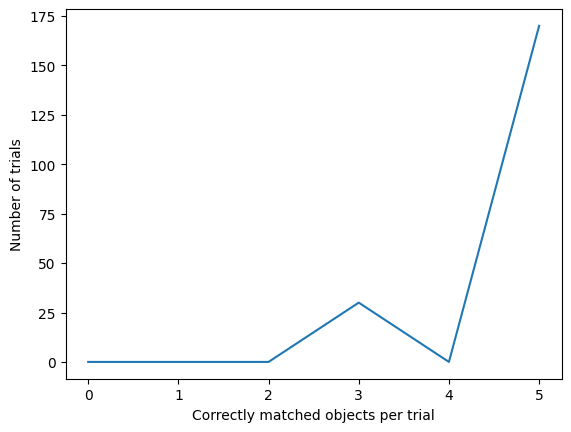

In [ ]:
# hungarian tests
from scipy.optimize import linear_sum_assignment
import numpy as np

def hungarian_test(model, num_trials, num_objects=5, disp=True):
  # Load all test images
  test_path =  '/scratch/merged/test'

  categories = os.listdir(test_path)
  test_classes = []
  for ctg in categories:
    for i in os.listdir(os.path.join(test_path, ctg)):
      test_classes.append(ctg + '/' + i)

  test_classes = sorted(test_classes)

  test_images = [
      os.listdir(os.path.join(
          test_path,
          c
      )) for c in test_classes
  ]

  for i in range(len(test_classes)):
    for j in range(len(test_images[i])):
      test_images[i][j] = os.path.join(test_path, test_classes[i], test_images[i][j])

  # for num_trials, load two sets of images, containing the same categories of images, from different views
  with torch.no_grad():
    total_associations = 0
    correct_associations = 0
    num_correct = [0]*(num_objects+1)

    for trial in tqdm(range(num_trials)):
      # choose categories, load images for both sets
      chosen_objects = random.sample([i for i in range(len(test_classes))], num_objects)

      set1 = []; set2 = []
      for o in chosen_objects:
        a,b = random.sample(test_images[o], 2)

        set1.append(PIL.Image.open(a))
        set2.append(PIL.Image.open(b))

      # display images if needed
      if disp and trial == 0:
        fig1, axs1 = plt.subplots(1, len(set1), figsize=(2*len(set1), 2))
        for i, img in enumerate(set1):
          axs1[i].set_title(str(i))
          axs1[i].imshow(img)
        plt.subplots_adjust(wspace=0.4)
        plt.show()

        fig2, axs2 = plt.subplots(1, len(set2), figsize=(2*len(set2), 2))
        for i, img in enumerate(set2):
          axs2[i].set_title(str(i))
          axs2[i].imshow(img)
        plt.subplots_adjust(wspace=0.4)
        plt.show()
        print()

      # get embeddings
      embs1 = []; embs2 = []
      for a,b in zip(set1, set2):
        ima = test_transforms(a)
        ka = model(ima.unsqueeze(0).cuda(), output_hidden_states=True).last_hidden_state[0,0,:]
        embs1.append(ka)

        imb = test_transforms(b)
        kb = model(imb.unsqueeze(0).cuda(), output_hidden_states=True).last_hidden_state[0,0,:]
        embs2.append(kb)
      embs1 = torch.stack(embs1)
      embs2 = torch.stack(embs2)

      # get cosine similarity, run hungarian
      scores = (F.cosine_similarity(embs1.unsqueeze(0), embs2.unsqueeze(1), axis=-1)).detach().cpu().numpy()

      cost_matrix = 1 - scores
      row_idx, col_idx = linear_sum_assignment(cost_matrix)

      # update statistics
      numcor = 0
      for i,j in zip(row_idx, col_idx):
        if i == j:
          numcor += 1

      total_associations += len(row_idx)
      correct_associations += numcor
      num_correct[numcor] += 1


      # display similarity heatmap if required, for the first iteration
      if disp and trial == 0:
        print("Hungarian algorithm")
        print(row_idx, col_idx)
        plt.imshow(scores, cmap='hot', interpolation='nearest')

        plt.colorbar()
        plt.xlabel('Img 2')
        plt.ylabel('Img 1')

        for i in range(scores.shape[0]):
          for j in range(scores.shape[1]):
            text = f'{scores[i, j]:.2f}'  # Format score to two decimal placesg

            if scores[i,j] > 0.5:
              text_color = 'black'
            else:
              text_color = 'white'

            if row_idx[i] == j:
              text_color = 'blue'
              text_weight = 'bold'
            else:
              text_weight=None

            plt.text(j, i, text, ha='center', va='center', color=text_color, fontweight=text_weight)

        plt.clim(0, 1);
        plt.show()
        print()

        print(f"{numcor} correct out of {num_objects}")
        print()

  # display the final calculated statistics
  print(f"{num_trials} trials run, {100*float(correct_associations)/total_associations}% of objects correctly matched")


  print(num_correct)
  plt.plot(np.linspace(0, num_objects, num=(num_objects+1)), num_correct)
  plt.xlabel('Correctly matched objects per trial')
  plt.ylabel('Number of trials')
  plt.title('')
  plt.show()

hungarian_test(lora_model, 200, disp=True)